# N-Gram Interpolation and Domain Adaptation Study

### 1. Experiment Summary

This study evaluates the effectiveness of **Linear Interpolation** for adapting N-gram language models to **Simulated Low-Resource** domains. We investigate whether blending a robust "General" model with a sparse "Domain" model improves predictive performance (Perplexity) and generative quality.

### Experimental Setup
We conduct three experiments using **Bigram (N=2)** and **Trigram (N=3)** models with varying **Laplace Smoothing**:

### Metrics
1. **Perplexity (PP):** Quantifies how "surprised" the model is by the test data. Lower is better. 
2. **OOV Rate:** The percentage of tokens in the test set that are Out-Of-Vocabulary for the model.
3. **Generation:** Qualitative assessment of the text generated by the interpolated model.


In [1]:
import pandas as pd
import math
import re
import random
import os
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import brown

# Ensure Brown corpus is available for Experiment B
try:
    nltk.data.find('corpora/brown')
except LookupError:
    nltk.download('brown')

# Global storage for summary statistics
EXPERIMENT_RESULTS = []

## 2. Shared Implementation
We define a reusable N-gram class that supports variable order (N) and smoothing (k), along with a standardized cleaning pipeline.

In [2]:
#Preprocessing Text
def standardize_text(text):
    """
    Aggressive cleaning to maximize vocabulary overlap.
    Retains only lowercase a-z and single spaces.
    """
    if not isinstance(text, str): return ""
    text = text.lower()
    text = text.replace('<unk>', '') 
    text = re.sub(r'[^a-z\s]', ' ', text)
    return " ".join(text.split())

#Logging and Visualization
def plot_experiment(title, results):
    """
    Plots Perplexity vs. Lambda for multiple configurations.
    results: dict { 'Label': ([lambdas], [perplexities]) }
    """
    plt.figure(figsize=(10, 6))
    
    for label, (x, y) in results.items():
        plt.plot(x, y, marker='o', label=label)
        
    plt.title(title)
    plt.xlabel('Lambda (Weight of Domain Model)')
    plt.ylabel('Perplexity (Lower is Better)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

def calculate_oov_rate(train_vocab, test_corpus):
    """Calculates % of test tokens not in training vocabulary."""
    test_tokens = [w for s in test_corpus for w in s.split()]
    if not test_tokens: return 0.0
    
    oov_count = sum(1 for w in test_tokens if w not in train_vocab)
    return (oov_count / len(test_tokens)) * 100

def log_best_result(exp_name, n, k, lambdas, perps):
    """Finds the best lambda for a run and saves it to global stats."""
    best_perp = min(perps)
    best_idx = perps.index(best_perp)
    best_lam = lambdas[best_idx]
    
    EXPERIMENT_RESULTS.append({
        "Experiment": exp_name,
        "N-Gram": n,
        "Smoothing (k)": k,
        "Best Lambda": best_lam,
        "Best Perplexity": round(best_perp, 2)
    })
    return best_lam

#Base N-Gram Model
class NGramModel:
    def __init__(self, n=2, k=1.0):
        self.n = n
        self.k = k 
        self.counts = defaultdict(Counter)
        self.vocab = set()

    def train(self, corpus):
        # 1. Build Global Vocab (Frequency > 1)
        all_tokens = [w for s in corpus for w in s.split()]
        counts = Counter(all_tokens)
        
        for sentence in corpus:
            # 2. Tokenize & Pad
            tokens = ["<s>"] * (self.n - 1) + \
                     [w if counts[w] > 1 else "<UNK>" for w in sentence.split()] + \
                     ["</s>"]
            
            self.vocab.update(tokens)

            # 3. Count N-grams
            for i in range(len(tokens) - (self.n - 1)):
                context = tuple(tokens[i:i+(self.n-1)])
                target = tokens[i+(self.n-1)]
                self.counts[context][target] += 1

    def get_prob(self, context, target):
        """Returns P(target | context) with Laplace Smoothing"""
        context_count = sum(self.counts[context].values())
        target_count = self.counts[context][target]
        
        # Laplace: (C + k) / (N + k*|V|)
        numerator = target_count + self.k
        denominator = context_count + (self.k * len(self.vocab))
        
        if denominator == 0:
            return 1.0 / len(self.vocab) if len(self.vocab) > 0 else 0.0
        return numerator / denominator

#Interpolator and Generator
class Interpolator:
    def __init__(self, gen_model, dom_model, lambd=0.5):
        self.gen = gen_model
        self.dom = dom_model
        self.lambd = lambd
        self.n = dom_model.n

    def score_sentence(self, sentence):
        words = sentence.split()
        padding = ["<s>"] * (self.n - 1)
        
        # Tokenize for both models (handling their specific vocabularies)
        gen_toks = padding + [w if w in self.gen.vocab else "<UNK>" for w in words] + ["</s>"]
        dom_toks = padding + [w if w in self.dom.vocab else "<UNK>" for w in words] + ["</s>"]

        log_prob = 0.0
        N = 0

        for i in range(len(dom_toks) - (self.n - 1)):
            # General Probability
            g_ctx = tuple(gen_toks[i:i+(self.n-1)])
            g_tgt = gen_toks[i+(self.n-1)]
            p_gen = self.gen.get_prob(g_ctx, g_tgt)
            
            # Domain Probability
            d_ctx = tuple(dom_toks[i:i+(self.n-1)])
            d_tgt = dom_toks[i+(self.n-1)]
            p_dom = self.dom.get_prob(d_ctx, d_tgt)
            
            # Linear Interpolation
            p_mix = (self.lambd * p_dom) + ((1 - self.lambd) * p_gen)
            
            if p_mix > 0:
                log_prob += math.log(p_mix)
            else:
                log_prob += math.log(1e-10)
            N += 1
            
        return log_prob, N

    def perplexity(self, test_corpus):
        total_log_prob = 0.0
        total_N = 0
        for s in test_corpus:
            if not s.strip(): continue
            lp, n = self.score_sentence(s)
            total_log_prob += lp
            total_N += n
        if total_N == 0: return float('inf')
        return math.exp(-total_log_prob / total_N)
    
    def generate(self, max_len=15):
        """
        Generates text by sampling from the interpolated distribution.
        Optimization: Only samples from words that exist in the context of either model.
        """
        context = ["<s>"] * (self.n - 1)
        sent = []
        
        for _ in range(max_len):
            # Get plausible candidates (optimization for speed)
            # We look at what both models have actually seen after this context
            ctx_tuple = tuple(context)
            gen_cands = list(self.gen.counts[ctx_tuple].keys())
            dom_cands = list(self.dom.counts[ctx_tuple].keys())
            candidates = list(set(gen_cands + dom_cands))
            
            if not candidates:
                # If dead end, fallback to common words or break
                break
                
            # Calculate P(w|context) for these candidates
            probs = []
            for w in candidates:
                gen_w = w if w in self.gen.vocab else "<UNK>"
                dom_w = w if w in self.dom.vocab else "<UNK>"
                
                p_gen = self.gen.get_prob(tuple(context), gen_w)
                p_dom = self.dom.get_prob(tuple(context), dom_w)
                probs.append((self.lambd * p_dom) + ((1 - self.lambd) * p_gen))
            
            # Sample
            if sum(probs) == 0: break
            next_word = random.choices(candidates, weights=probs, k=1)[0]
            
            if next_word == "</s>": break
            sent.append(next_word)
            
            # Update context
            context.pop(0)
            context.append(next_word)
            
        return " ".join(sent)

## Experiment A: Cross-Domain Mismatch (WikiText vs. Medical)

Due to the heterogeneity in vocabulary between the WikiText and Medical sets, domain adaptation with linear interpolation was broadly unsuccessful

Processing N=2, k=0.1...
   OOV Rate (Gen): 19.33%, (Dom): 12.17%
   Generated Text (Lambda=0.8): "concept of commentators blamed by mothers evan found medially at league cup <UNK> blotches behind"
Processing N=2, k=1.0...
   OOV Rate (Gen): 19.33%, (Dom): 12.17%
   Generated Text (Lambda=0.8): "yamaha in greek word surfaced runways are supported ian on blind he learns boxing he"
Processing N=3, k=0.1...
   OOV Rate (Gen): 19.33%, (Dom): 12.17%
   Generated Text (Lambda=1.0): "wasp has a vast treasure of written tradition according to natalie nichols noted that at"
Processing N=3, k=1.0...
   OOV Rate (Gen): 19.33%, (Dom): 12.17%
   Generated Text (Lambda=1.0): "between and"


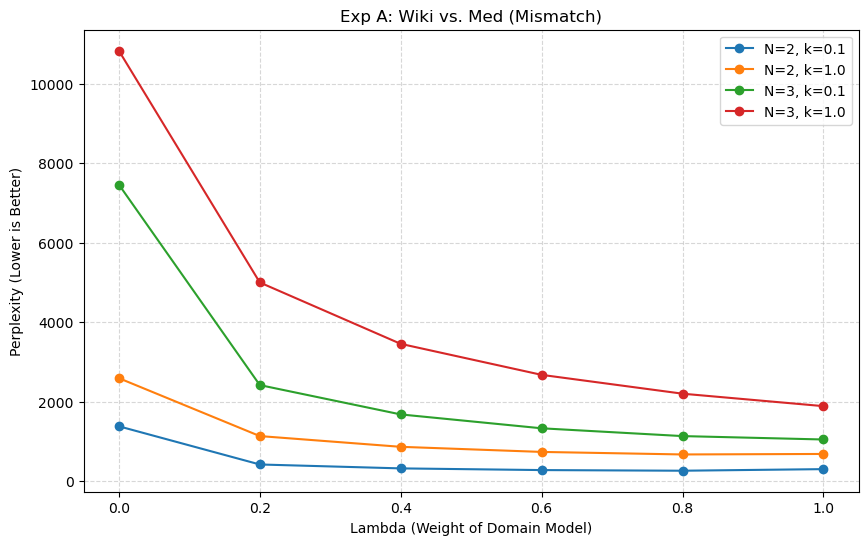

In [3]:
def run_experiment_a():
    # 1. Load Data
    wiki_path = './data/ngram_data/train-00000-of-00001.parquet'
    med_path = './data/ngram_data/mtsamples.csv'

    if not os.path.exists(wiki_path) or not os.path.exists(med_path):
        print("Data files missing. Skipping Exp A.")
        return

    wiki_df = pd.read_parquet(wiki_path)
    med_df = pd.read_csv(med_path)
    
    # 2. Clean & Split
    wiki_clean = [standardize_text(s) for s in wiki_df['text'] if len(str(s)) > 30]
    med_clean = [standardize_text(s) for s in med_df['transcription'] if len(str(s)) > 30]
    
    # Low Resource Split: Train on 100 docs, Test on rest
    med_train, med_test = train_test_split(med_clean, train_size=100, random_state=42)
    
    results = {}
    lambdas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

    # 3. Run Variations (N=2/3, k=0.1/1.0)
    for n in [2, 3]:
        for k in [0.1, 1.0]:
            label = f"N={n}, k={k}"
            print(f"Processing {label}...")
            
            # Train Models
            gen = NGramModel(n, k)
            gen.train(wiki_clean[:5000]) # Subsample Wiki
            
            dom = NGramModel(n, k)
            dom.train(med_train)
            
            # OOV Check
            oov_gen = calculate_oov_rate(gen.vocab, med_test)
            oov_dom = calculate_oov_rate(dom.vocab, med_test)
            print(f"   OOV Rate (Gen): {oov_gen:.2f}%, (Dom): {oov_dom:.2f}%")
            
            # Evaluate Interpolation
            perps = []
            for lam in lambdas:
                model = Interpolator(gen, dom, lam)
                perps.append(model.perplexity(med_test[:200])) 
            
            results[label] = (lambdas, perps)
            best_lam = log_best_result("Exp A (Mismatch)", n, k, lambdas, perps)
            
            # GENERATION CHECK
            best_model = Interpolator(gen, dom, best_lam)
            print(f"   Generated Text (Lambda={best_lam}): \"{best_model.generate()}\"")

    # 4. Visualize
    plot_experiment("Exp A: Wiki vs. Med (Mismatch)", results)

run_experiment_a()

## Experiment B: Vocabulary Overlap (Brown News vs. Romance)
Here we enforce a shared vocabulary (Top 2000 words) to verify that interpolation works when domains speak the "same language."

Processing N=2, k=0.1...
   OOV Rate (Gen): 2.25%, (Dom): 32.18%
   Generated Text (Lambda=1.0): "urged in marriage will march of some voice vote for them would ever saw that"
Processing N=2, k=1.0...
   OOV Rate (Gen): 2.25%, (Dom): 32.18%
   Generated Text (Lambda=1.0): "gets so obvious are well ."
Processing N=3, k=0.1...
   OOV Rate (Gen): 2.25%, (Dom): 32.18%
   Generated Text (Lambda=1.0): "federal <UNK> bank have even been serious <UNK> of fulton county , <UNK> friday and"
Processing N=3, k=1.0...
   OOV Rate (Gen): 2.25%, (Dom): 32.18%
   Generated Text (Lambda=1.0): "we are , so that a list which she has kept the pressure on ."


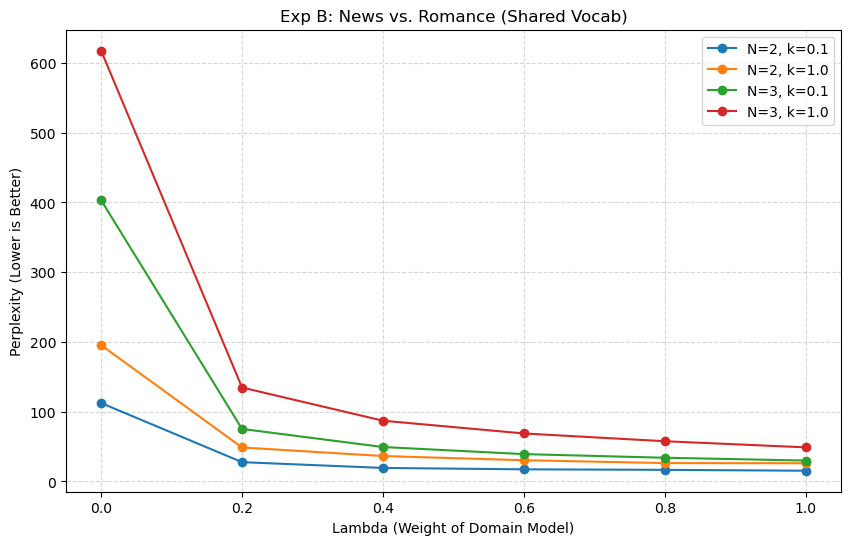

In [7]:
def run_experiment_b():
    # 1. Prepare Data
    news = [" ".join(s) for s in brown.sents(categories='news')]
    romance = [" ".join(s) for s in brown.sents(categories='romance')]
    
    # 2. Build Shared Vocabulary
    all_words = [w.lower() for s in news + romance for w in s.split()]
    common = {w for w, c in Counter(all_words).most_common(2000)}
    
    def restrict(sent):
        return " ".join([w.lower() if w.lower() in common else "<UNK>" for w in sent.split()])
    
    gen_corpus = [restrict(s) for s in news]
    dom_corpus = [restrict(s) for s in romance]
    
    # Starvation Split: Train on 50, Test on rest
    dom_train = dom_corpus[:50]
    dom_test = dom_corpus[50:]

    results = {}
    lambdas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

    # 3. Run Variations
    for n in [2, 3]:
        for k in [0.1, 1.0]:
            label = f"N={n}, k={k}"
            print(f"Processing {label}...")
            
            gen = NGramModel(n, k)
            gen.train(gen_corpus)
            
            dom = NGramModel(n, k)
            dom.train(dom_train)
            
            # OOV Check
            oov_gen = calculate_oov_rate(gen.vocab, dom_test)
            oov_dom = calculate_oov_rate(dom.vocab, dom_test)
            print(f"   OOV Rate (Gen): {oov_gen:.2f}%, (Dom): {oov_dom:.2f}%")
            
            perps = []
            for lam in lambdas:
                model = Interpolator(gen, dom, lam)
                # Evaluate on sample
                perps.append(model.perplexity(random.sample(dom_test, 200)))
            
            results[label] = (lambdas, perps)
            best_lam = log_best_result("Exp B (Overlap)", n, k, lambdas, perps)

            # GENERATION CHECK
            best_model = Interpolator(gen, dom, best_lam)
            print(f"   Generated Text (Lambda={best_lam}): \"{best_model.generate()}\"")

    # 4. Visualize
    plot_experiment("Exp B: News vs. Romance (Shared Vocab)", results)

run_experiment_b()

## Experiment C: Specialty Adaptation (General Medical vs. Surgery)
Adapting a General Medical model to a specific Surgery sub-domain. We use a "starved" surgery training set (50 docs) to force reliance on the general model.

Processing N=2, k=0.1...
   OOV Rate (Gen): 0.40%, (Dom): 13.64%
   Generated Text (Lambda=0.4): "athlete who appears normal craniovertebral junction obstruction mild prematurity and scrub it subjective the al"
Processing N=2, k=1.0...
   OOV Rate (Gen): 0.40%, (Dom): 13.64%
   Generated Text (Lambda=0.6): "progress with foraminal stenosis history the trap and asked what appeared patent mm spiral possible"
Processing N=3, k=0.1...
   OOV Rate (Gen): 0.40%, (Dom): 13.64%
   Generated Text (Lambda=0.2): "preoperative diagnoses change in her headaches have become more alert and oriented african american female"
Processing N=3, k=1.0...
   OOV Rate (Gen): 0.40%, (Dom): 13.64%
   Generated Text (Lambda=1.0): "sample address re mrs sample patient is experiencing mild fevers and again both testes were"


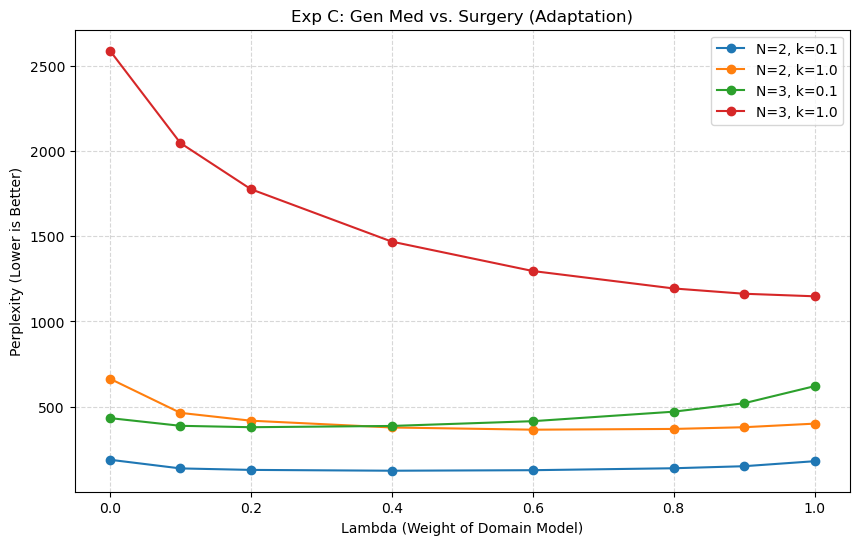

In [5]:
def run_experiment_c():
    # 1. Load & Filter
    if not os.path.exists('./data/ngram_data/mtsamples.csv'): return
    df = pd.read_csv('./data/ngram_data/mtsamples.csv')
    
    surgery = df[df['medical_specialty'].str.contains('Surgery', case=False, na=False)]
    general = df[~df['medical_specialty'].str.contains('Surgery', case=False, na=False)]
    
    # 2. Clean
    gen_corpus = [standardize_text(t) for t in general['transcription'] if len(str(t)) > 50]
    surg_corpus = [standardize_text(t) for t in surgery['transcription'] if len(str(t)) > 50]
    
    # 3. Starvation Split
    surg_train, surg_test = train_test_split(surg_corpus, train_size=50, test_size=100, random_state=42)
    
    results = {}
    lambdas = [0.0, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0]

    # 4. Run Variations
    for n in [2, 3]:
        for k in [0.1, 1.0]:
            label = f"N={n}, k={k}"
            print(f"Processing {label}...")
            
            gen = NGramModel(n, k)
            gen.train(gen_corpus)
            
            dom = NGramModel(n, k)
            dom.train(surg_train)
            
            # OOV Check
            oov_gen = calculate_oov_rate(gen.vocab, surg_test)
            oov_dom = calculate_oov_rate(dom.vocab, surg_test)
            print(f"   OOV Rate (Gen): {oov_gen:.2f}%, (Dom): {oov_dom:.2f}%")
            
            perps = []
            for lam in lambdas:
                model = Interpolator(gen, dom, lam)
                perps.append(model.perplexity(surg_test))
            
            results[label] = (lambdas, perps)
            best_lam = log_best_result("Exp C (Adaptation)", n, k, lambdas, perps)

            # GENERATION CHECK
            best_model = Interpolator(gen, dom, best_lam)
            print(f"   Generated Text (Lambda={best_lam}): \"{best_model.generate()}\"")

    # 5. Visualize
    plot_experiment("Exp C: Gen Med vs. Surgery (Adaptation)", results)

run_experiment_c()

## 3. Final Results Summary

In [6]:
# Display Summary DataFrame
if EXPERIMENT_RESULTS:
    summary_df = pd.DataFrame(EXPERIMENT_RESULTS)
    print("\n=== FINAL RESULTS SUMMARY ===")
    print(summary_df.sort_values(by=["Experiment", "N-Gram", "Smoothing (k)"]).to_string(index=False))



=== FINAL RESULTS SUMMARY ===
        Experiment  N-Gram  Smoothing (k)  Best Lambda  Best Perplexity
  Exp A (Mismatch)       2            0.1          0.8           257.73
  Exp A (Mismatch)       2            1.0          0.8           667.34
  Exp A (Mismatch)       3            0.1          1.0          1044.16
  Exp A (Mismatch)       3            1.0          1.0          1883.77
   Exp B (Overlap)       2            0.1          1.0            15.31
   Exp B (Overlap)       2            1.0          1.0            25.64
   Exp B (Overlap)       3            0.1          1.0            35.25
   Exp B (Overlap)       3            1.0          1.0            52.33
Exp C (Adaptation)       2            0.1          0.4           124.06
Exp C (Adaptation)       2            1.0          0.6           364.87
Exp C (Adaptation)       3            0.1          0.2           379.39
Exp C (Adaptation)       3            1.0          1.0          1147.67
